In [1]:
import fsspec
import cf_xarray
import xarray as xr

In [2]:
# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='s3://nextgen-dmac/nos/nos.dbofs.fields.best.nc.zarr', remote_protocol='s3', remote_options={'anon':True, 'use_ssl': False}, target_protocol='s3', target_options={'anon':True, 'use_ssl': False})
m = fs.get_mapper("") 

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={'ocean_time':1})
ds

<xarray.Dataset>
Dimensions:        (ocean_time: 786, tracer: 2, s_rho: 10, s_w: 11,
                    boundary: 4, eta_rho: 732, xi_rho: 119, eta_psi: 731,
                    xi_psi: 118, eta_u: 732, xi_u: 118, eta_v: 731, xi_v: 119)
Coordinates:
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2023-05-27T01:00:00 ... 2023-0...
  * s_rho          (s_rho) float64 -0.95 -0.85 -0.75 -0.65 ... -0.25 -0.15 -0.05
  * s_w            (s_w) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... -0.3 -0.2 -0.1 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/79)
    Akk_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak        (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_r           (ocean_time, s_rho) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    Cs_w           (ocean_time, s_w) float64 dask.array<chunksize=(1, 11), meta=np.ndarray>
    ...             ...
    theta_s        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    u              (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 10, 732, 118), meta=np.ndarray>
    v              (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 10, 731, 119), meta=np.ndarray>
    w              (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 6, 732, 119), meta=np.ndarray>
    xl             (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
Attributes: (12/33)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bry_file_01:       nos.dbofs.obc.20230527.t00z.nc
    ...                ...
    svn_url:           
    tide_file:         nos.dbofs.roms.tides.nc
    tiling:            008x016
    title:             dbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml

In [48]:
from pyproj import Transformer

x_lng = ds['lon_rho'].values.flatten()
y_lat = ds['lat_rho'].values.flatten()
z = ds['temp'].cf.isel(time=0, vertical=0).values.flatten()

to_merc = Transformer.from_crs(4326, 3857, always_xy=True)
x, y = to_merc.transform(x_lng, y_lat)


In [26]:
import datashader as dsh
import datashader.transfer_functions as tf
import datashader.utils as dshu
import pandas as pd
from scipy.spatial import Delaunay
import numpy as np

In [49]:
%%time
verts = pd.DataFrame(np.stack((x,y,z)).T, columns=['x', 'y', 'z'])
triang = Delaunay(verts[['x','y']].values)
tris = pd.DataFrame(triang.simplices, columns=['v0', 'v1', 'v2'])

CPU times: user 628 ms, sys: 21.9 ms, total: 650 ms
Wall time: 662 ms


In [50]:
cvs = dsh.Canvas(plot_height=512,plot_width=512)

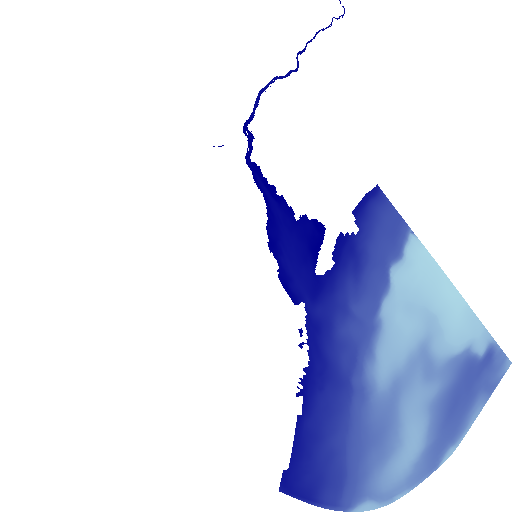

In [51]:
mesh = dshu.mesh(verts,tris)
cvs = dsh.Canvas(plot_height=512, plot_width=512)
agg = cvs.trimesh(verts, tris, mesh=mesh)
tf.shade(agg)

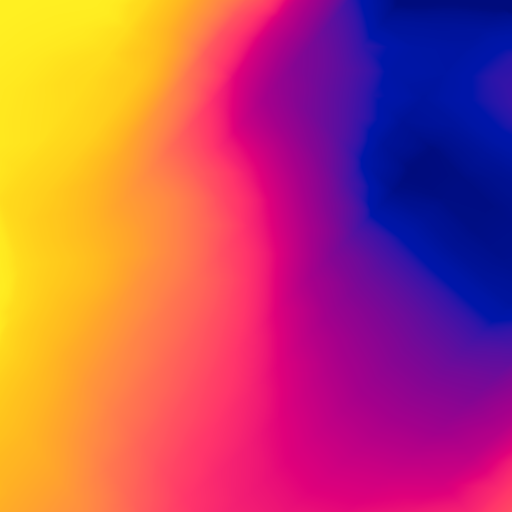

In [53]:
from colorcet import bmy as c


# http://localhost:8090/datasets/dbofs/wms/?service=WMS&version=1.3.0&request=GetMap&layers=salt&crs=EPSG:3857&bbox=-8296780.798186172,4657155.259359218,-8257645.039704161,4696291.017841227&width=512&height=512&styles=raster/default&colorscalerange=0.005000028293579817,35.58600616455078&time=2023-06-28T12:00:00Z
cvs = dsh.Canvas(plot_height=512, plot_width=512, x_range=(-8296780.798186172, -8257645.039704161), y_range=(4657155.259359218, 4696291.017841227))

img = tf.shade(cvs.trimesh(verts, tris, mesh=mesh, interp=True),  cmap=c)
dshu.export_image(img, 'dbofs.png')